# AI-Medic Asignment 2 - Machine Learning

Name: Mohammad Arabzadeh  
Email: a.mohamad7824@gmail.com

In this project, I'm going to try to train the cifar10 dataset using MLP. Although image datasets are better be trained with CNN models, it is possible to achieve rough predictions just by using simple MLP models. 

## 1. Hyperparameter Tuning

First, I'll import only one batch of the cifar10 dataset, which includes 10,000 images, and try to find optimal hyperparameters. In the next section, I'll use these hyperparameters to train the whole dataset. 

### Importing the Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        data = pickle.load(fo, encoding='bytes')
    return data

The files are assumed to be in "/content/drive/MyDrive/AIMedic/proj_2" path.

In [3]:
meta_dict = unpickle('/content/drive/MyDrive/AIMedic/proj_2/batches.meta')
data_dict = unpickle('/content/drive/MyDrive/AIMedic/proj_2/data_batch_1')

### Storing the Data

Now, I'll save the values that we need in appropriate variables. 

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
## Save label names in meta
meta = list(meta_dict[b'label_names'])

## Values in meta are in 'bytes' type. we'll convert them to strings
meta = [item.decode('utf-8') for idx, item in enumerate(meta)]

In [6]:
## Save labels values in a numpy array
labels_raw = np.array(data_dict[b'labels'])

print(labels_raw.shape)
print(labels_raw)

(10000,)
[6 9 9 ... 1 1 5]


In [7]:
## Save image data values in a numpy array
data_raw = np.array(data_dict[b'data'])

print(data_raw.shape)
print(data_raw[0])

(10000, 3072)
[ 59  43  50 ... 140  84  72]


### Exploring the Data

Class numbers and what they represent:

In [8]:
for idx, item in enumerate(meta):
    print("Class {}:".format(idx), item)

Class 0: airplane
Class 1: automobile
Class 2: bird
Class 3: cat
Class 4: deer
Class 5: dog
Class 6: frog
Class 7: horse
Class 8: ship
Class 9: truck


Number of data in each class:

In [9]:
print(np.array(np.unique(labels_raw, return_counts=True)))

[[   0    1    2    3    4    5    6    7    8    9]
 [1005  974 1032 1016  999  937 1030 1001 1025  981]]


Shape of image data:

In [10]:
print(data_raw.shape)

(10000, 3072)


3072 = 32 x 32 x 3   
First and second 32 are height and width of the image, and 3 is the number of channels (which are red, green, and blue).  
We need to first reshape the image data into a (width x height x num_channel) shape for *matplotlib* to recognize the images. We'll do this in the next part

#### Taking a Look at the Images

As said before, we need to reshape the data first: 

In [11]:
data_reshaped = data_raw.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

print("New shape =", data_reshaped.shape, "= (img_idx, width, height, num_channel)")

New shape = (10000, 32, 32, 3) = (img_idx, width, height, num_channel)


Now we can take a peak at some of the images in the dataset: 

(32, 32, 3)


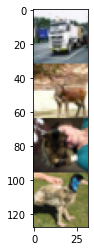

In [12]:
sample_img = data_reshaped[1000]
print(sample_img.shape)

plt.imshow(np.array(data_reshaped[1000:1004].reshape(32*4,32,3), dtype='uint8'))

### Pre-Processing the Data

#### One hot encoding

In [13]:
labels = np.zeros((len(labels_raw), len(meta)))
    
for idx, val in enumerate(labels_raw):
    labels[idx][val] = 1

print(labels_raw[0:10])
print(labels[0:10])

[6 9 9 4 1 1 2 7 8 3]
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


#### Gray Scaling

The classes of this dataset seems to be less dependant on the colors of the images. Also by training the model with colored images and comparing to the model with the model trained by the gray-scaled images, I realized that they perform somewhat similar to each other. So in order to have a less complex model, I decided to use the gray-scaled images. 

In [14]:
def gray_scale(raw):
    return raw.reshape(-1, 3, 1024).mean(axis=1)

data_gray = gray_scale(data_raw) 

print(data_gray.shape)
print(data_gray[0])

(10000, 1024)
[ 61.33333333  44.66666667  47.         ... 180.         117.66666667
  95.66666667]


#### Resizing to 16x16

Using the 32x32 images for the model, I realized that assigning an adequate value to the number of hidden layer neurons is too frustrating; increasing or decreasing the number of neurons didn't seem to have forsighted outcomes. Maybe this was a result of the features being too complex for an MLP model. So in order to achieve more simplification, I decided to downsize the images to 16x16. 

In [15]:
from skimage.transform import resize
def resize_32_to_16(raw):
    reshaped = raw.reshape(-1, 32, 32)
    data_16 = np.empty((reshaped.shape[0], 16, 16))
    for idx, val in enumerate(reshaped):
        data_16[idx] = resize(val, (16, 16))
    return data_16.reshape(-1, 16*16)


data_16 = resize_32_to_16(data_gray)

In [16]:
print(data_16.shape)

(10000, 256)


#### Normalization

Normalization is an inevitable step for training any dataset on an MLP model. For this data set, I used per-image global centering and standardization method to normalize the data. [[Image normalization methods](https://machinelearningmastery.com/how-to-manually-scale-image-pixel-data-for-deep-learning/)]

In [17]:
def normalize(raw):
    return (raw - raw.mean(axis=0)) / raw.std(axis=0)

data_16_norm = normalize(data_16)

### Train-Validation Split

In [18]:
def shuffle(x, y):
    inx = np.random.permutation(x.shape[0])
    return x[inx], y[inx]

In [19]:
def split(x, y, train_ratio):
    split = int(x.shape[0] * train_ratio)
    return x[:split], x[split:], y[:split], y[split:]

In [20]:
X, Y = shuffle(data_16_norm, labels)

X_train, X_val, Y_train, Y_val = split(X, Y, 0.9)

In [21]:
print(X_train.shape)
print(X_val.shape)
print(Y_train.shape)
print(Y_val.shape)

(9000, 256)
(1000, 256)
(9000, 10)
(1000, 10)


#### Augmentation: Adding horizontally flipped images to the training dataset

Comparing the results of some models with and without augmented training datasets, I came to a conclusion that the model perform better in terms of loss values if the augmented training set is used. 

In [22]:
def augment(x, y):
    x_reshaped = x.reshape(-1, 16, 16)
    x_flipped = np.flip(x_reshaped, axis=2)
    x_re_reshaped = x_flipped.reshape(-1, 16*16)
    return np.append(x, x_re_reshaped, axis=0), np.append(y, y, axis=0)

In [23]:
X_train_aug, Y_train_aug = augment(X_train, Y_train)

print(X_train_aug.shape, Y_train_aug.shape)

(18000, 256) (18000, 10)


### Model and Hyperparameter Tuning

#### First Layer

To tune the hyperparameters for the first layer, these constants were used: 
- ReLU activation function
- Adam optimizer with learning_rate=0.0003 
- epochs=50  
- batch_size=32  

Also in all the tables, d:0.1 means Dropout layer with 'rate'=0.1  

|Layers              |Train Acc|Val Acc|Train Loss|Val Loss|Val Loss Trend
|:-------------------|:--------|:------|:---------|:-------|:-----
|[1000]              |0.94     |0.40   |0.25      |1.80    |Increasing
|[d:0.5, 1000]       |0.49     |0.40   |1.49      |1.79    |Relatively fixed
|[1000, d:0.5]       |0.64     |0.44   |1.06      |1.70    |Relatively increasing (overfit)
|[d:0.8, 1000]       |0.35     |0.29   |1.83      |2.16    |Increasing
|[d:0.5, 2000]       |0.49     |0.41   |1.47      |1.78    |Unstable
|[500]               |0.86     |0.39   |0.48      |1.75    |Increasing
|[d:0.4, 500]        |0.51     |0.41   |1.40      |1.80    |Relatively fixed
|[500, d:0.4]        |0.61     |0.42   |1.13      |1.70    |Relatively increasing (overfit)
|[d:0.4, 300]        |0.49     |0.39   |1.46      |1.76    |Relatively fixed
|[300, d:0.4]        |0.55     |0.42   |1.28      |1.70    |Fixed (overfit)
|[200, d:0.2]        |0.59     |0.42   |1.20      |1.70    |Fixed (overfit)
|[d:0.4, 200]        |0.48     |0.40   |1.49      |1.74    |Fixed
|[200, d:0.4]        |0.52     |0.41   |1.38      |1.71    |Fixed
|[d:0.2, 200, d:0.4] |0.44     |0.40   |1.60      |1.70    |Relatively decreasing
|[d:0.3, 200, d:0.4] |0.42     |0.40   |1.66      |1.72    |Relatively fixed
|[d:0.1, 200, d:0.5] |0.44     |0.41   |1.60      |1.70    |Relatively fixed
|[d:0.2, 100, d:0.4] |0.40     |0.40   |1.70      |1.74    |Relatively decreasing
|[d:0.1, 100, d:0.4] |0.41     |0.41   |1.65      |1.72    |Relatively decreasing
|[d:0.1, 100, d:0.5] |0.40     |0.39   |1.72      |1.75    |Decreasing
|[d:0.1, 100, d:0.6] |0.37     |0.37   |1.78      |1.77    |Decreasing
|[d:0.05, 50, d:0.2] |0.42     |0.38   |1.63      |1.78    |Fixed
|[d:0.1, 150, d:0.4] |0.45     |0.40   |1.58      |1.71    |Fixed
|[d:0.1, 150, d:0.3] |0.47     |0.41   |1.52      |1.70    |Fixed
|[d:0.1, 150, d:0.5] |0.42     |0.39   |1.64      |1.73    |Fixed

Candidates for the next part are [d:0.2, 100, d:0.4], [d:0.1, 100, d:0.5], and [d:0.1, 150, d:0.4]. 

#### Activations Functions

Now we'll train each model with different activation functions for 200 epochs and compare their performance. 

|Layers             |Func|Train Acc|Val Acc|Train Loss|Val Loss|Val Loss Trend
|:------------------|:---|:--------|:------|:---------|:-------|:-----
|[d:0.2, 100, d:0.4]|ReLU|0.42     |0.40   |1.64      |1.71    |Fixed after 75 epoch
|[d:0.2, 100, d:0.4]|SMax|0.41     |0.37   |1.68      |1.82    |Fixed after 130 epoch
|[d:0.2, 100, d:0.4]|Tanh|0.39     |0.37   |1.72      |1.77    |Fixed after 150 epoch
|[d:0.1, 100, d:0.5]|ReLU|0.41     |0.40   |1.64      |1.73    |Fixed after 60 epoch
|[d:0.1, 100, d:0.5]|SMax|0.40     |0.37   |1.68      |1.83    |Fixed after 130 epoch
|[d:0.1, 100, d:0.5]|Tanh|0.38     |0.37   |1.75      |1.78    |Fixed after 160 epoch
|[d:0.1, 150, d:0.4]|ReLU|0.49     |0.41   |1.46      |1.73    |Fixed after 75 epoch
|[d:0.1, 150, d:0.4]|SMax|0.46     |0.36   |1.53      |1.84    |Increasing after 80 epoch
|[d:0.1, 150, d:0.4]|Tanh|0.44     |0.38   |1.59      |1.74    |Fixed after 130 epoch

ReLU gives the best results for all architectures. Also, [d:0.2, 100, d:0.4] has the best results between others; so we'll only use this for the next models.

#### Optimizers

Now we'll test different optimizers and learning rates.  
layer = [d:0.2, 100, d:0.4] relu  
epochs = 200  

|Optimizer|L-Rate|Train Acc|Val Acc|Train Loss|Val Loss|Notes
|:--------|:-----|:--------|:------|:---------|:-------|:-----
|Adam     |0.0003|0.42     |0.39   |1.64      |1.74    |Small fluctuations in train and val
|Adam     |0.0001|0.41     |0.38   |1.67      |1.72    |Smooth val curve, little fluctuations in train
|SGD      |0.006 |0.40     |0.40   |1.70      |1.72    |Little fluctuations in train
|Adagrad  |0.01  |0.40     |0.38   |1.70      |1.74    |Little fluctuations in train
|Adadelta |0.3   |0.42     |0.39   |1.64      |1.74    |Relatively smooth curves, val loss a little increasing after 100 epochs
|Adadelta |0.1   |0.42     |0.41   |1.66      |1.72    |Good curves (little fluctuations)
|RMSprop  |0.0001|0.41     |0.40   |1.68      |1.74    |Good curves (little fluctuations)

Adadelta with 0.1 learning rate seems to be better than others. Let's see other learning rates for this optimizer (after 200 epochs): 

|Optimizer|L-Rate|Train Acc|Val Acc|Train Loss|Val Loss|Notes
|:--------|:-----|:--------|:------|:---------|:-------|:-----
|Adadelta |0.1   |0.42     |0.41   |1.66      |1.72    |Good curves (little fluctuations)
|Adadelta |1     |0.42     |0.40   |1.67      |1.77    |Too much fluctuations, increasing val loss
|Adadelta |0.01  |0.32     |0.34   |1.92      |1.87    |Too slow

Based on the results, the best optimizer is Adadelta with learning_rate=0.1. 

#### Adding a New Layer

Now we'll add a new layer after the [d:0.2, 100, d:0.4] and see the performance after 200 epochs: 

|New Layers         |Train Acc|Val Acc|Train Loss|Val Loss|Val Loss Trend
|:------------------|:--------|:------|:---------|:-------|:-----
|Without new layers |0.42     |0.41   |1.66      |1.72    |Fixed
|[100]              |0.44     |0.41   |1.58      |1.69    |Fixed (a little overfit)
|[50]               |0.43     |0.40   |1.61      |1.70    |Fixed (a little overfit)
|[200]              |0.45     |0.41   |1.54      |1.67    |Fixed (overfit)
|[400]              |0.47     |0.39   |1.50      |1.70    |Fixed (overfit)
|[500, d:0.5]       |0.43     |0.40   |1.62      |1.65    |Fluctuations

It seems that adding new layers don't affect the performance too much. So We'll stick with the old architecture.

#### Epochs and Batch Size

  
Now we'll find the optimum values for epochs and batch size.  

|Epochs|Batch Size|Train Acc|Val Acc|Train Loss|Val Loss|Notes
|:-----|:---------|:--------|:------|:---------|:-------|:-----
|200   |32        |0.42     |0.41   |1.66      |1.72    |
|200   |64        |0.41     |0.40   |1.70      |1.70    |
|200   |16        |0.41     |0.41   |1.67      |1.70    |
|200   |128       |0.40     |0.40   |1.72      |1.71    |
|400   |128       |0.41     |0.40   |1.67      |1.69    |After 250 epochs, there's not much change in val loss
|400   |64        |0.42     |0.41   |1.64      |1.69    |After 350 epochs, there's not much change in val loss
|350   |64        |0.42     |0.40   |1.65      |1.69    |
|300   |32        |0.42     |0.39   |1.64      |1.69    |

The best choice is epochs=350 and batch_size=64.  
Now we can train the model on all batches of the dataset! 

#### Final Model

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.optimizers import RMSprop

In [25]:
def tuned_nn(X_train, Y_train, X_val, Y_val):
    ## Model architecture
    model = Sequential()
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu', input_dim=256))
    model.add(Dropout(0.4))
    model.add(Dense(10, activation='softmax'))
    
    ## Compiling the model
    model.compile(optimizer=Adadelta(learning_rate=0.1), loss='categorical_crossentropy', metrics=['acc'])
    
    ## Fitting the model
    hist = model.fit(X_train, Y_train, batch_size=32, epochs=300, validation_data=(X_val, Y_val))
    return hist, model

## 2. Training the Model

### Importing All Batches

In [26]:
meta_dict = unpickle('/content/drive/MyDrive/AIMedic/proj_2/batches.meta')
print(meta_dict)

{b'num_cases_per_batch': 10000, b'label_names': [b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck'], b'num_vis': 3072}


In [27]:
data_dict_1 = unpickle('/content/drive/MyDrive/AIMedic/proj_2/data_batch_1')
data_dict_2 = unpickle('/content/drive/MyDrive/AIMedic/proj_2/data_batch_2')
data_dict_3 = unpickle('/content/drive/MyDrive/AIMedic/proj_2/data_batch_3')
data_dict_4 = unpickle('/content/drive/MyDrive/AIMedic/proj_2/data_batch_4')
data_dict_5 = unpickle('/content/drive/MyDrive/AIMedic/proj_2/data_batch_5')

test_dict = unpickle('/content/drive/MyDrive/AIMedic/proj_2/test_batch')

### Storing the Data

In [28]:
import numpy as np

In [29]:
meta = list(meta_dict[b'label_names'])

meta = [item.decode('utf-8') for idx, item in enumerate(meta)]

In [30]:
labels_raw = np.concatenate([data_dict_1[b'labels'], 
                             data_dict_2[b'labels'],
                             data_dict_3[b'labels'],
                             data_dict_4[b'labels'],
                             data_dict_5[b'labels']])

print(labels_raw.shape)
print(labels_raw)

(50000,)
[6 9 9 ... 9 1 1]


In [31]:
data_raw = np.concatenate([data_dict_1[b'data'], 
                           data_dict_2[b'data'],
                           data_dict_3[b'data'],
                           data_dict_4[b'data'],
                           data_dict_5[b'data']])

print(data_raw.shape)
print(data_raw[0])

(50000, 3072)
[ 59  43  50 ... 140  84  72]


In [32]:
test_labels_raw = np.array(data_dict[b'labels'])
print(test_labels_raw.shape)

test_data_raw = np.array(data_dict[b'data'])
print(test_data_raw.shape)

(10000,)
(10000, 3072)


### Pre-Processing

One hot encoding: 

In [33]:
labels = np.zeros((len(labels_raw), len(meta)))
    
for idx, val in enumerate(labels_raw):
    labels[idx][val] = 1

print(labels.shape)

(50000, 10)


In [34]:
test_labels = np.zeros((len(test_labels_raw), len(meta)))
    
for idx, val in enumerate(test_labels_raw):
    test_labels[idx][val] = 1

print(test_labels.shape)

(10000, 10)


Gray scaling, resizing and normalization:

In [35]:
data_gray = gray_scale(data_raw) 
data_16 = resize_32_to_16(data_gray)
data_16_norm = normalize(data_16)

In [36]:
test_data_gray = gray_scale(test_data_raw) 
test_data_16 = resize_32_to_16(test_data_gray)
test_data_16_norm = normalize(test_data_16)

### Train-Validation Split

In [37]:
X, Y = shuffle(data_16_norm, labels)

X_train, X_val, Y_train, Y_val = split(X, Y, 0.98)

print(X_train.shape)
print(X_val.shape)
print(Y_train.shape)
print(Y_val.shape)

(49000, 256)
(1000, 256)
(49000, 10)
(1000, 10)


In [38]:
X_train_aug, Y_train_aug = augment(X_train, Y_train)

print(X_train_aug.shape, Y_train_aug.shape)

(98000, 256) (98000, 10)


### Model

The model was trained and saved into the 'cifar10.h5' file with this piece of code using Google Colab. I'll load the model for evaluations. 
```
hist, model = tuned_nn(X_train_aug, Y_train_aug, X_val, Y_val)
model.save('/content/drive/MyDrive/AIMedic/proj_2/cifar10.h5')
```

In [39]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/AIMedic/proj_2/cifar10.h5')

## 3. Evaluations

In [40]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

Turning the labels back to the original form:

In [41]:
y_true = test_labels_raw
y_pred = model.predict(test_data_16_norm).argmax(axis=1)

print(y_true, y_pred)

[6 9 9 ... 1 1 5] [6 1 9 ... 9 1 7]


#### Loss and Accuracy

In [42]:
eval = model.evaluate(test_data_16_norm, test_labels)
print("\nTesting loss = {:.2f}".format(eval[0]))
print("Testing accuracy = {:.2f}%".format(eval[1]*100))

313/313 [==============================] - 1s 2ms/step - loss: 1.5416 - acc: 0.4686

Testing loss = 1.54
Testing accuracy = 46.86%


#### Classification Report

In [43]:
## Classification report
class_rep = classification_report(y_true, y_pred, target_names=meta)

print(class_rep)

              precision    recall  f1-score   support

    airplane       0.51      0.45      0.48      1005
  automobile       0.64      0.47      0.54       974
        bird       0.33      0.32      0.33      1032
         cat       0.37      0.23      0.28      1016
        deer       0.34      0.51      0.41       999
         dog       0.47      0.38      0.42       937
        frog       0.43      0.69      0.53      1030
       horse       0.62      0.50      0.56      1001
        ship       0.51      0.60      0.55      1025
       truck       0.61      0.53      0.57       981

    accuracy                           0.47     10000
   macro avg       0.48      0.47      0.47     10000
weighted avg       0.48      0.47      0.47     10000



#### Confusion Matrix

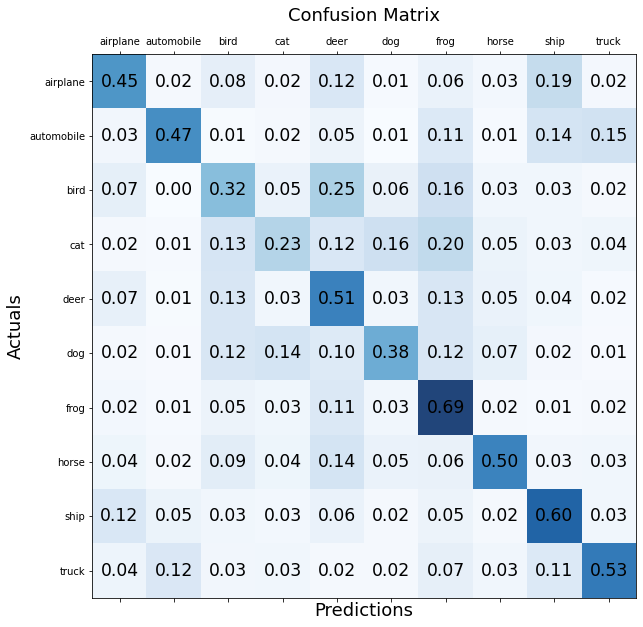

In [44]:
## Confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)
norm_conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

## Plotting
fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(norm_conf_mat, cmap=plt.cm.Blues, alpha=0.9)

for i in range(norm_conf_mat.shape[0]):
    for j in range(norm_conf_mat.shape[1]):
        ax.text(x=j, y=i, s="{:.2f}".format(norm_conf_mat[i, j]), va='center', ha='center', size='xx-large')

ax.set_xticks(list(range(10)))
ax.set_yticks(list(range(10)))
ax.set_xticklabels(meta)
ax.set_yticklabels(meta)

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

#### Accuracy Per Class

In [45]:
## Accuracy Per Class
acc = norm_conf_mat.diagonal()

## Printing
print("{:13s}accuracy\n".format(''))
for idx, val in enumerate(acc):
    print("{:13s}{:.2f}".format(meta[idx], val))

             accuracy

airplane     0.45
automobile   0.47
bird         0.32
cat          0.23
deer         0.51
dog          0.38
frog         0.69
horse        0.50
ship         0.60
truck        0.53


## 4. Final Notes

Based on my searches, I found three models that used MLP (links are given in the references section). The reported accuracies were 37%, 55%, and 59%. This model was able to somewhat reach these accuracies (46%).  
It is obvious that we have to use more complex models than MLP, like CNN. We can see in [this page](https://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d3130) that people have been able to achieve above 90% accuracies using more complicated models.  

## 5. References

Some of the references that I used in order to complete this project: 
- cifar10 with CNN: https://towardsdatascience.com/cifar-10-image-classification-in-tensorflow-5b501f7dc77c  
- Normalization: https://machinelearningmastery.com/how-to-manually-scale-image-pixel-data-for-deep-learning/  
- ReLu:
 1. https://datascience.stackexchange.com/questions/5706/what-is-the-dying-relu-problem-in-neural-networks
 2. https://datascience.stackexchange.com/questions/23493/why-relu-is-better-than-the-other-activation-functions
 3. input normalization: https://datascience.stackexchange.com/questions/25832/input-normalization-for-relu
- NN architechture: 
 1. https://towardsdatascience.com/beginners-ask-how-many-hidden-layers-neurons-to-use-in-artificial-neural-networks-51466afa0d3e
 2. https://stats.stackexchange.com/questions/213478/number-of-neurons-in-the-output-layer
- Validation: 
 1. https://stats.stackexchange.com/questions/104713/hold-out-validation-vs-cross-validation
 2. https://en.wikipedia.org/wiki/Cross-validation_(statistics)#Non-exhaustive_cross-validation
 3. https://medium.com/@eijaz/holdout-vs-cross-validation-in-machine-learning-7637112d3f8f
 4. https://towardsdatascience.com/understanding-8-types-of-cross-validation-80c935a4976d
- Confusion matrix plot code: https://vitalflux.com/python-draw-confusion-matrix-matplotlib/
- Other mlp implementations for this dataset: 
 1. 59% acc, ReLU, hidden_units=[7000, 6000]: https://github.com/parvathic/ml-cifar10/tree/master/MLP%20code
 2. 55% acc, [1536, 768, 384, 128] ReLU: https://towardsdatascience.com/implementing-a-deep-neural-network-for-the-cifar-10-dataset-c6eb493008a5
 3. 37% acc, [256, 128]: https://pvss.github.io/MLP+of+CIFAR-10
- Reported accuracies for cifar10: https://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d3130
